In [1]:
# !pip install seaborn

In [1]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL, BNode
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.community as nx_comm
import seaborn as sns
import networkx as nx
from owlready2 import *

In [11]:
# Load your TTL file
g = rdflib.Graph()
#Change the file name/ path here 
g.parse("Project/merged_individuals_updated_v2.ttl", format="ttl") 

<Graph identifier=Na54df27996d24cafa39fbf0544783677 (<class 'rdflib.graph.Graph'>)>

To investigate the data and its characteristics, we applied a number of methods including both visual and numerical summaries. As we observe the content of the ontology and the semantics of the relations between its different entities, the aim is to identify any peculiarities in the data that require more research and can lead to new ideas on how to process and further analyze the data using a novel approach. This section outlines the findings from the data analysis based on the ontology described in section 2.

## Numerical Summaries

In order to better understand the nature of the data we are dealing with, we start by looking whether the graph is connected or not. Since there are nodes in the graph that are not reachable from another part of the graph, we are working with a disconnected graph. This is also supported by the way it was build as it is composed of separate subontologies that were merged into one large one.

In [4]:
g.connected()

False

Since we obtained a False result when testing for connectedness, we know that our graph is made up of several components. More insights about these componented can be obtained by generating an overview of the stronger and weaker components (connected nodes) in the ontology. 

In [4]:
nx_graph = rdflib_to_networkx_digraph(g)

In [6]:
# Strongly Connected Components
strongly_connected_components = list(nx.strongly_connected_components(nx_graph))

strong_data = []
for idx, component in enumerate(strongly_connected_components):
    strong_data.append({
        'Component': idx + 1,
        'Nodes': list(component),
        'Node Count': len(component)
    })

strong_df = pd.DataFrame(strong_data)
strong_df = strong_df.sort_values(by='Node Count', ascending=False).reset_index(drop=True)

# Weakly Connected Components
weakly_connected_components = list(nx.weakly_connected_components(nx_graph))

weak_data = []
for idx, component in enumerate(weakly_connected_components):
    weak_data.append({
        'Component': idx + 1,
        'Nodes': list(component),
        'Node Count': len(component)
    })


weak_df = pd.DataFrame(weak_data)
weak_df = weak_df.sort_values(by='Node Count', ascending=False).reset_index(drop=True)

print("Strongly Connected Components (Sorted by Node Count):")
print(strong_df)

print("\nWeakly Connected Components (Sorted by Node Count):")
print(weak_df)


Strongly Connected Components (Sorted by Node Count):
      Component                                              Nodes  Node Count
0            17  [n05d80511edee45a699d48ccc663ab3aeb19, http://...           6
1           241  [http://www.semanticweb.org/vbr240/ontologies/...           4
2           975  [http://www.owl-ontologies.com/hi#DeepInteract...           3
3            18  [http://www.semanticweb.org/vbr240/ontologies/...           3
4            50  [http://www.semanticweb.org/hi_ontology#Topogr...           2
...         ...                                                ...         ...
1866       1835                 [https://w3id.org/mod#createdWith]           1
1867       1836  [two agents depend on each other but for diffe...           1
1868       1837  [http://www.semanticweb.org/vbr240/ontologies/...           1
1869       1838  [http://www.semanticweb.org/vbr240/ontologies/...           1
1870          1    [http://www.w3.org/2002/07/owl#NamedIndividual]           

- The Weakly Connected Components indicate that, while many nodes may not be directly connected through directed edges, they can still be reached when ignoring edge direction. The single large Component 1 suggests that the overall ontology is loosely connected when viewed without regard to the directionality of the relationships between nodes.
- The Strongly Connected Components, on the other hand, reveal a more fragmented structure where most nodes are isolated or belong to small, tightly-knit groups. This reflects the typical nature of ontologies or directed graphs, where many entities (nodes) might not be interlinked in a way that forms cycles or strong connectivity. Many of the components consist of just a single node, indicating the presence of isolated or specialized concepts that don't have direct connections to other nodes.

In [27]:
def check_blanks(graph):
    count = 0
    blanks = []
    nodes = list(graph.nodes())

    print("Checking for blank nodes:")
    for node in nodes:
        if isinstance(node,BNode):
            print(node)
            blanks.append(node)
            count+=1
    print(f"Total number of blank nodes in the graph: {count}")
    return blanks, count 

blanks, counts = check_blanks(nx_graph)

Checking for blank nodes:
n05d80511edee45a699d48ccc663ab3aeb2
n05d80511edee45a699d48ccc663ab3aeb6
n05d80511edee45a699d48ccc663ab3aeb7
n05d80511edee45a699d48ccc663ab3aeb14
n05d80511edee45a699d48ccc663ab3aeb11
n05d80511edee45a699d48ccc663ab3aeb21
n05d80511edee45a699d48ccc663ab3aeb3
n05d80511edee45a699d48ccc663ab3aeb9
n05d80511edee45a699d48ccc663ab3aeb12
n05d80511edee45a699d48ccc663ab3aeb13
n05d80511edee45a699d48ccc663ab3aeb16
n05d80511edee45a699d48ccc663ab3aeb18
n05d80511edee45a699d48ccc663ab3aeb8
n05d80511edee45a699d48ccc663ab3aeb19
n05d80511edee45a699d48ccc663ab3aeb20
n05d80511edee45a699d48ccc663ab3aeb10
n05d80511edee45a699d48ccc663ab3aeb17
n05d80511edee45a699d48ccc663ab3aeb1
n05d80511edee45a699d48ccc663ab3aeb15
n05d80511edee45a699d48ccc663ab3aeb4
n05d80511edee45a699d48ccc663ab3aeb5
n05d80511edee45a699d48ccc663ab3aeb22
Total number of blank nodes in the graph: 22


In [26]:
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))

Number of Nodes: 1884
Number of Edges: 3850
Density of Graph: 0.0010852492916281896


Next we compute some statistics about the nodes in the graph, namely the degree, closeness and betweenness centrality. 
Centrality measures tell us which nodes (things) are the most important in a network. Due to the fact that our graph is not connected, not all centrality meaures will be applicable. We chose to test degree and closeness centrality:  

#### Degree Centrality 
- **What it measures:** The number of direct connections a node has.  
- **Why it's useful:** Shows popular or highly connected nodes in a network.  
#### Closeness Centrality (How Fast You Can Reach Others)  
- **What it measures:** How quickly a node can reach all other nodes.  
- **Why it's useful:** Finds key spreaders of information (good for viral marketing or pandemics).  

Due to high variability in the frequencies of degrees, we applied logscaling and log binning to improve the readability of the distributions.

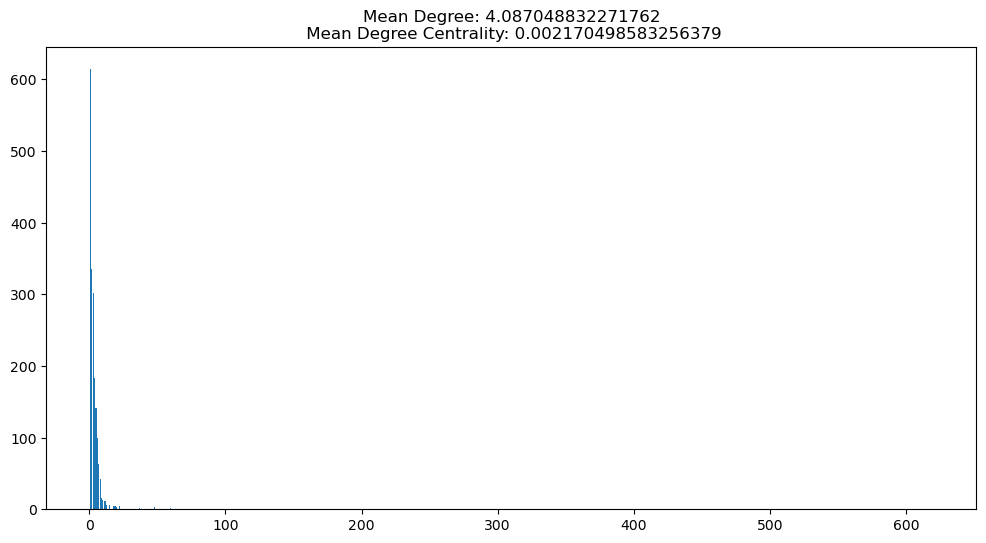

In [5]:
# Compute Degree centrality
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.savefig("Degree_1", dpi=300, bbox_inches='tight')  
plt.show()

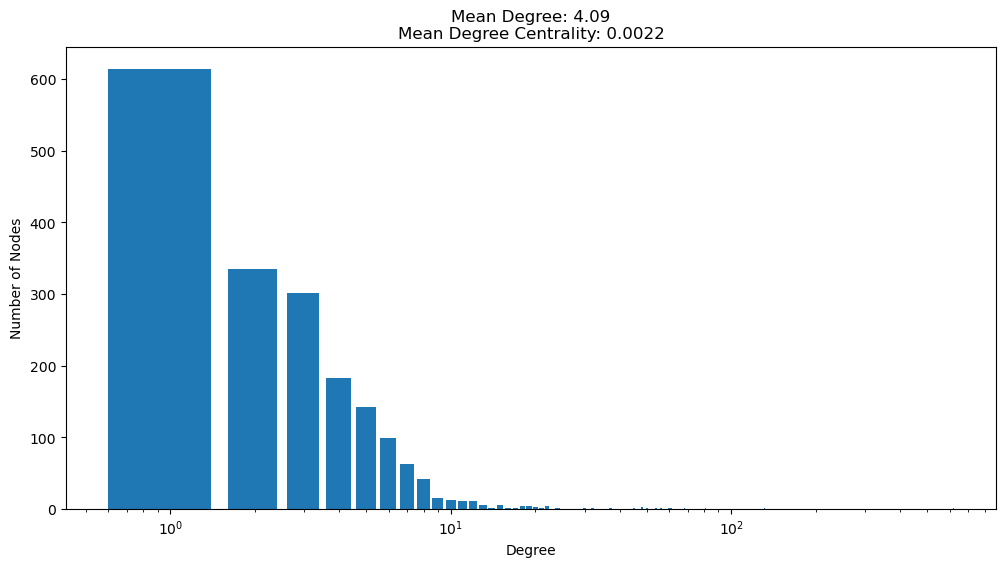

In [6]:
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph), columns=["Count"])
histdegree = histdegree[histdegree["Count"] > 0]  # Remove empty degree values

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(histdegree.index.values, histdegree["Count"])

plt.xscale("log")
plt.title(f"Mean Degree: {mean_degree:.2f}\nMean Degree Centrality: {mean_degree_centrality:.4f}")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.savefig("Degree_2", dpi=300, bbox_inches='tight')  
plt.show()

/var/folders/bl/dmz7fsdx52z5256m10zqn7t00000gp/T/ipykernel_16682/825215002.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  histdegree_grouped = histdegree.groupby("Degree Bin").sum()


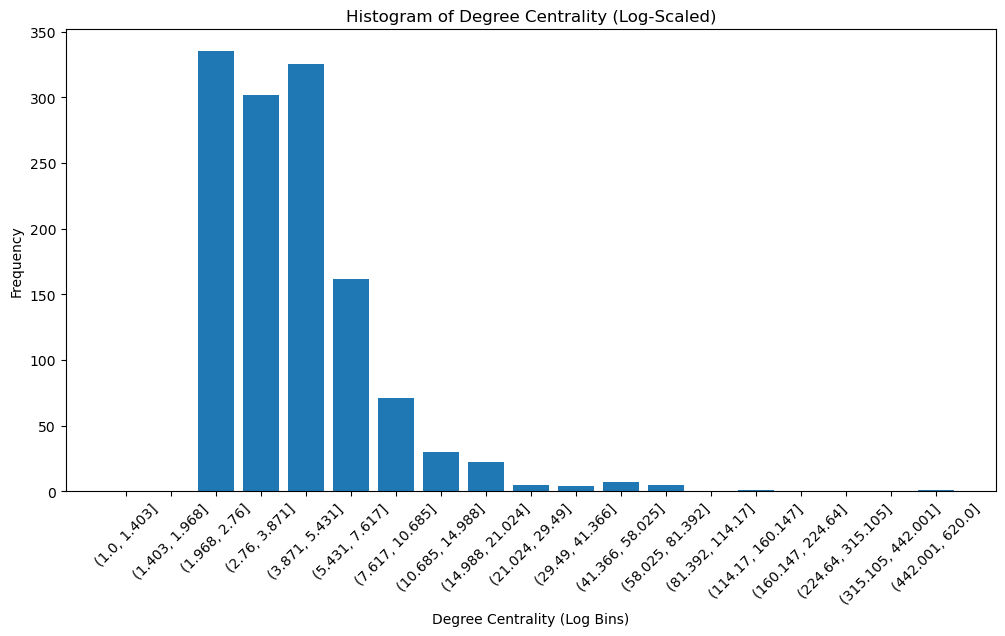

In [7]:
histdegree["Degree Bin"] = pd.cut(histdegree.index, bins=np.logspace(0, np.log10(histdegree.index.max()), 20))
histdegree_grouped = histdegree.groupby("Degree Bin").sum()

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(histdegree_grouped.index.astype(str), histdegree_grouped["Count"])
plt.xlabel("Degree Centrality (Log Bins)")
plt.ylabel("Frequency")
plt.title("Histogram of Degree Centrality (Log-Scaled)")
plt.xticks(rotation=45)
plt.savefig("Degree_3", dpi=300, bbox_inches='tight')  
plt.show()

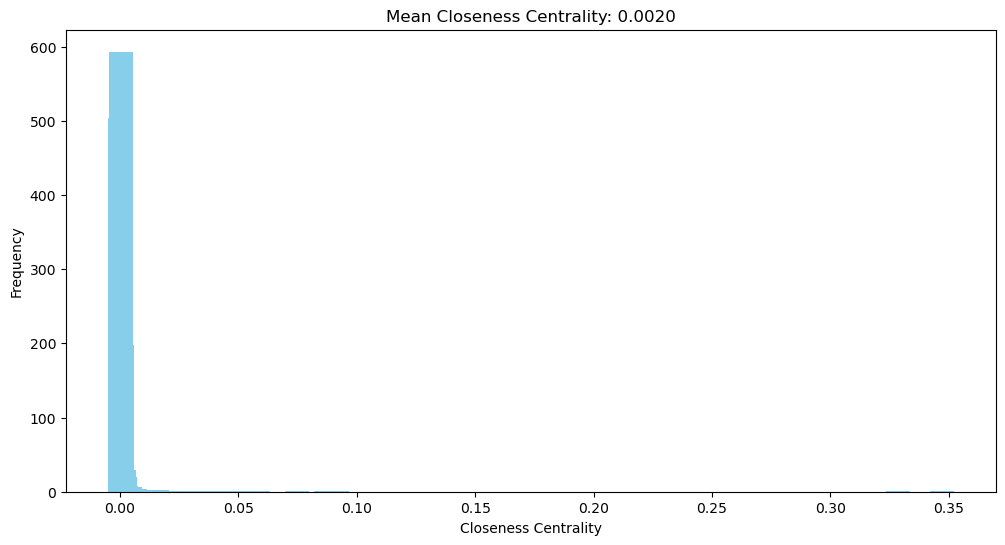

In [8]:
# Closeness centraliy measure
closeness_centrality = nx.closeness_centrality(nx_graph)
closeness_values = list(closeness_centrality.values())

hist_closeness = pd.Series(closeness_values).value_counts().sort_index()

# Mean closeness centrality
mean_closeness = np.mean(closeness_values)

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(hist_closeness.index, hist_closeness.values, width=0.01, color='skyblue')

plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.title(f"Mean Closeness Centrality: {mean_closeness:.4f}")
plt.savefig("Closeness_1", dpi=300, bbox_inches='tight') 
plt.show()

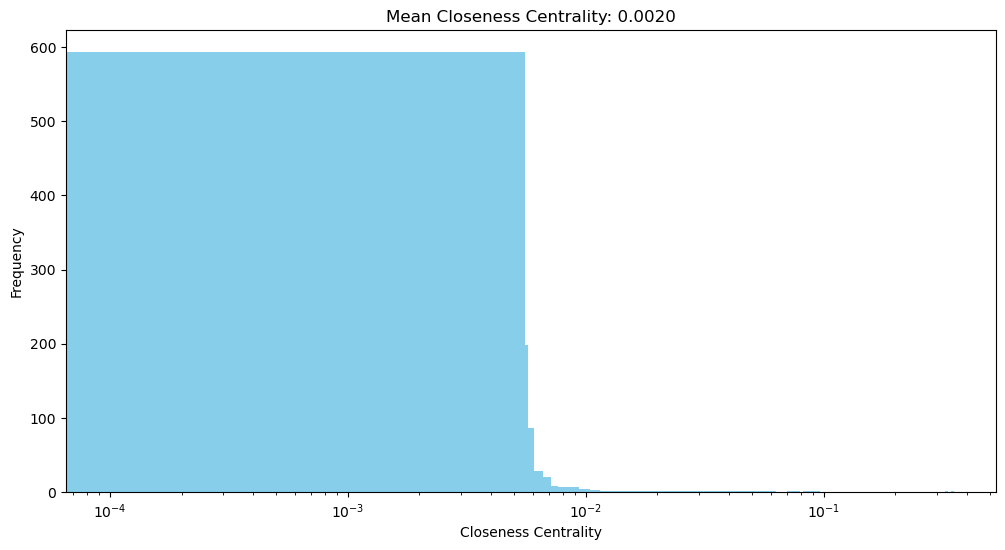

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(hist_closeness.index, hist_closeness.values, width=0.01, color='skyblue')
plt.xscale("log")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.title(f"Mean Closeness Centrality: {mean_closeness:.4f}")
plt.savefig("Closeness_2", dpi=300, bbox_inches='tight') 
plt.show()

/var/folders/bl/dmz7fsdx52z5256m10zqn7t00000gp/T/ipykernel_16682/3043072509.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  histcloseness_grouped = hist_closeness.groupby("Closeness Bin").size()


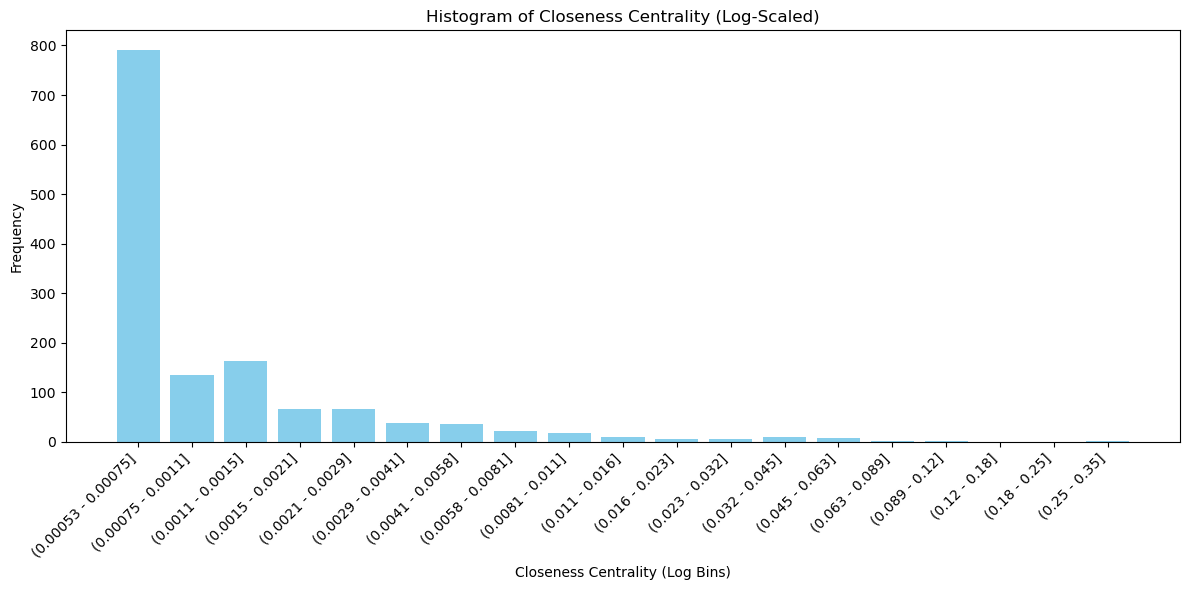

In [10]:
closeness_centrality = nx.closeness_centrality(nx_graph)
hist_closeness = pd.DataFrame(list(closeness_centrality.items()), columns=["Node", "Closeness"])
hist_closeness = hist_closeness[hist_closeness["Closeness"] > 0] 

# Ensure valid range for bins
min_bin = max(hist_closeness["Closeness"].min(), 1e-5) 
max_bin = hist_closeness["Closeness"].max()

bins = np.logspace(np.log10(min_bin), np.log10(max_bin), 20)  
# hist_closeness["Closeness Bin"] = pd.cut(hist_closeness["Closeness"], bins=bins)

# # Group by bin and count occurrences
# histcloseness_grouped = hist_closeness.groupby("Closeness Bin").size()

# # Plot the histogram
# fig, ax = plt.subplots(figsize=(12,6))
# ax.bar(histcloseness_grouped.index.astype(str), histcloseness_grouped.values, color="skyblue")
# plt.xticks(rotation=45)
# plt.xlabel("Closeness Centrality (Log Bins)")
# plt.ylabel("Frequency")
# plt.title("Histogram of Closeness Centrality (Log-Scaled)")
# plt.show()


bin_labels = [f"({bins[i]:.2} - {bins[i+1]:.2}]" for i in range(len(bins)-1)]
hist_closeness["Closeness Bin"] = pd.cut(hist_closeness["Closeness"], bins=bins, labels=bin_labels)

# Group by the custom bin labels and count occurrences
histcloseness_grouped = hist_closeness.groupby("Closeness Bin").size()

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(histcloseness_grouped.index, histcloseness_grouped.values, color="skyblue")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel("Closeness Centrality (Log Bins)")
plt.ylabel("Frequency")
plt.title("Histogram of Closeness Centrality (Log-Scaled)")
plt.tight_layout()
plt.savefig("Closeness_3", dpi=300, bbox_inches='tight') 
plt.show()

## Graph Visualization

In [15]:
graph = rdflib.Graph()
graph.parse("Project/merged_individuals.ttl", format="turtle")

# CONSTRUCT query to create simplified graph
query = """
CONSTRUCT {
  ?subject ?predicate ?object .
}
WHERE {
  ?subject a owl:NamedIndividual .
  ?subject ?predicate ?object .
  FILTER (!isLiteral(?object))
  FILTER (?object != owl:NamedIndividual)  # Exclude the owl statements
}
"""

result_graph = graph.query(query)
result_graph.serialize(destination="simple_merged.ttl", format="turtle")
print("New graph saved as simple_merged.ttl", len(result_graph))

New graph saved as simple_merged.ttl 1190


In [13]:
simple_ontology = rdflib.Graph()
#Change the file name/path
simple_ontology.parse("Project/merged_individuals_updated_v2.ttl")
simple_nx_graph = rdflib_to_networkx_digraph(simple_ontology)

In [17]:
from pyvis.network import Network
net = Network(notebook=True)
net.from_nx(simple_nx_graph)
net.show("graph_interactive.html")

graph_interactive.html


50 745


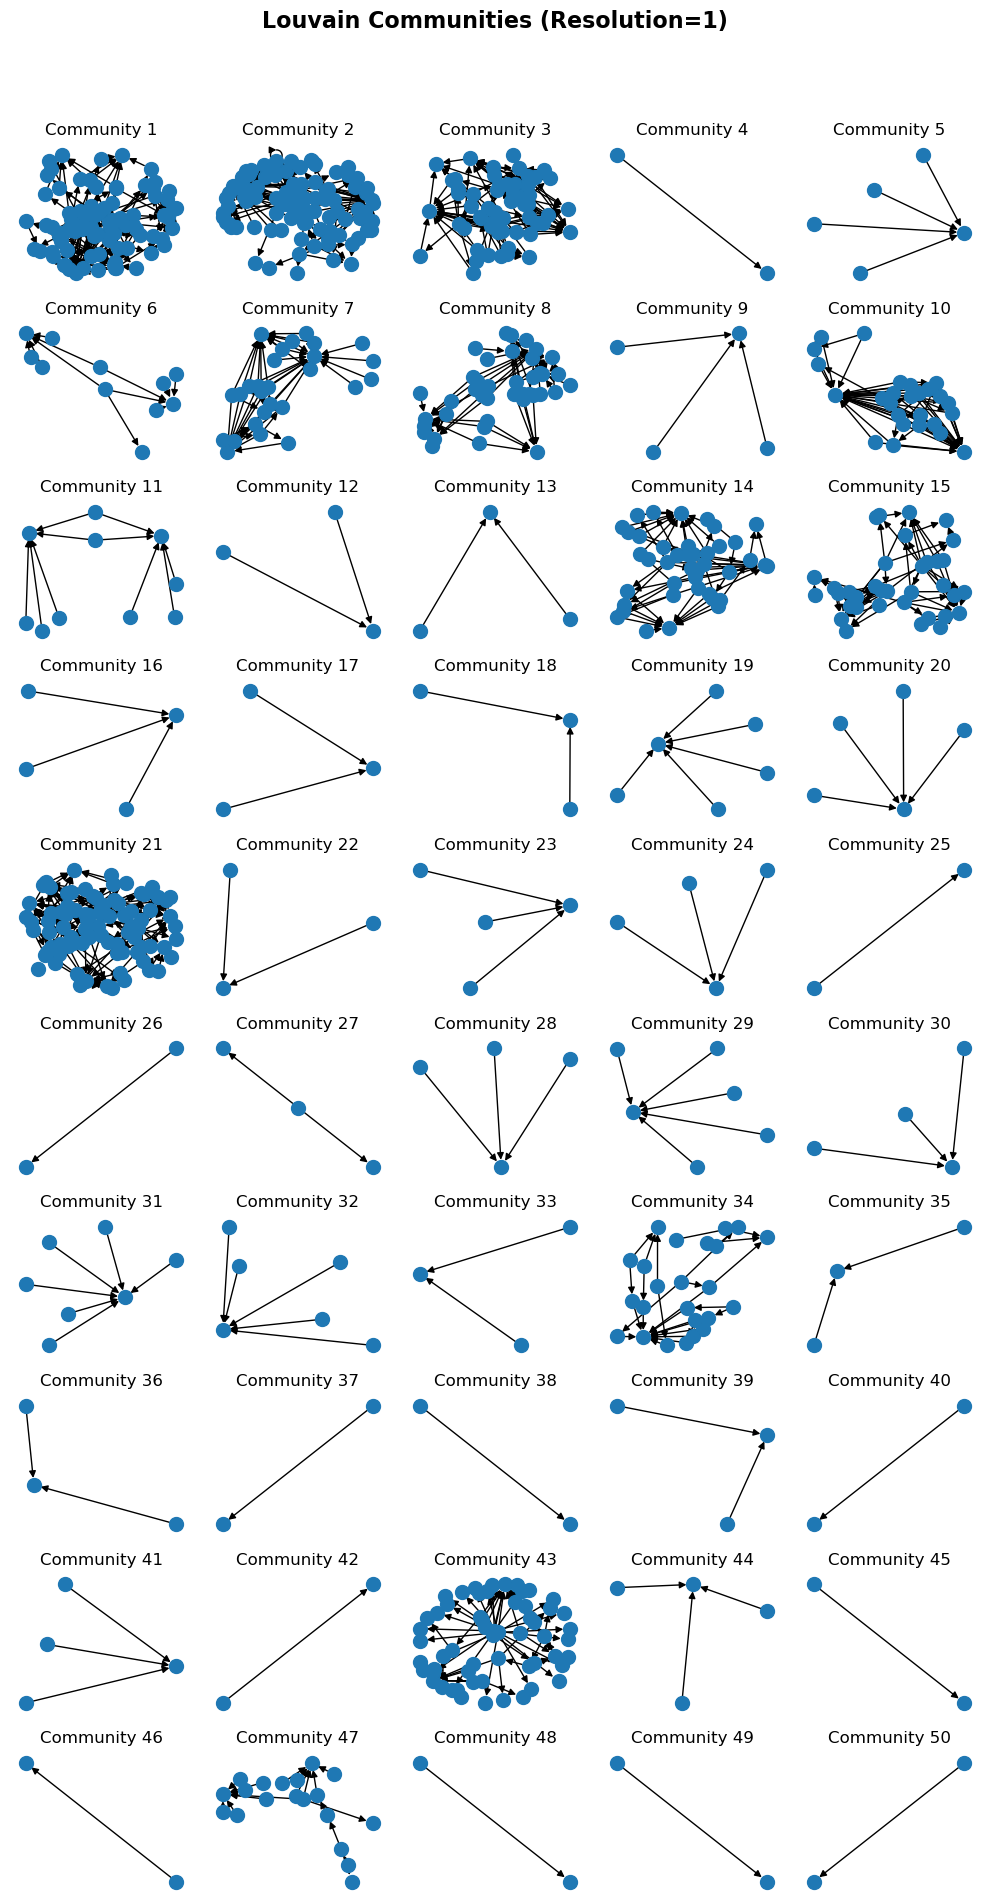

In [24]:
communities = nx_comm.louvain_communities(simple_nx_graph, resolution=1, seed=349)
print(len(communities), nx.number_of_nodes(simple_nx_graph))

# Create a plot with enough subplots to display all communities
num_communities = len(communities)
cols = 5  # Number of columns in the subplot grid
rows = (num_communities // cols) + (num_communities % cols > 0) 

fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
axes = axes.flatten() 

# Loop over each community and plot it in its respective subplot
for i, com in enumerate(communities):
    ax = axes[i]  # Get the current subplot
    subgraph = simple_nx_graph.subgraph(com)  # Get the subgraph for this community
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50)  # Positioning for subgraph nodes
    nx.draw(subgraph, pos, ax=ax, with_labels=False, node_size=100, font_size=10)
    ax.set_title(f"Community {i + 1}")  # Title for each subplot


for j in range(num_communities, len(axes)):
    axes[j].axis('off')

fig.suptitle('Louvain Communities (Resolution=1)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Reserve space for the main title
plt.savefig("louvain_communities_resolution_1.png", format="png")
plt.show()

## KG metrics and summary

First we inveetigate the basic metrics which are as follows (also confirmed using protege):
- Classes: 137
- Instances: 1032
- Properties: 92
- Triples: 4279
- Entities (classes, individuals, etc. anything that can be places in the subject possition in a triple/axiom): 1267

![Protégé Ontology Metrics](Protegè_Metrics.png)

In [25]:
hi_ontology = rdflib.Graph()
hi_ontology.parse("Project/merged_individuals.ttl")

print("Obtain metrics using queries:")

answer = list(hi_ontology.query(
    'PREFIX owl: <http://www.w3.org/2002/07/owl#> SELECT DISTINCT ?s WHERE { ?s rdf:type owl:Class. FILTER isURI(?s) }'
))
print("Number of classes: {f}".format(f=len(answer)))

# Query properties
properties = list(hi_ontology.query(
    'PREFIX owl: <http://www.w3.org/2002/07/owl#> SELECT DISTINCT ?p WHERE { ?p rdf:type owl:ObjectProperty. FILTER isURI(?p) }'
    # 'PREFIX owl: <http://www.w3.org/2002/07/owl#> SELECT (COUNT(DISTINCT ?p) AS ?C) WHERE {?s ?p ?o}'
))
print("Number of properties: {f}".format(f=len(properties)))
# print("Number of properties: {f}".format(f=properties[0][0]))
# for p in properties:
#     print(p)

# Query individuals
individuals = list(hi_ontology.query(
    'PREFIX owl: <http://www.w3.org/2002/07/owl#> SELECT DISTINCT ?s WHERE { ?s rdf:type owl:NamedIndividual. FILTER isURI(?s) }'
))
print("Number of individuals: {f}".format(f=len(individuals)))
# for indiv in individuals:
#     print(indiv)

# Query triples
triples = list(hi_ontology.query(
    'PREFIX owl: <http://www.w3.org/2002/07/owl#> SELECT (COUNT(*) AS ?C) WHERE {?s ?p ?o}'
))
print("Number of triples: {f}".format(f=triples[0][0]))

# Query entities
entities = list(hi_ontology.query(
    'PREFIX owl: <http://www.w3.org/2002/07/owl#> SELECT (COUNT(DISTINCT ?s) AS ?C) WHERE {?s ?p ?o}'
))
print("Number of entities: {f}".format(f=entities[0][0]))

Obtain metrics using queries:
Number of classes: 131
Number of properties: 81
Number of individuals: 620
Number of triples: 3861
Number of entities: 1275
